In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
except:
    os.chdir('Modules')
# from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

importing Jupyter notebook from Spike_Generation.ipynb


# Ganerate Spike from FBFF model (Poison)

## k_E and k_S

In [3]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [4]:
m = 4.037925
n =	100
alpha = 8.351984
beta = 3.123359
g =  442.699730/n
tau_y = 0.050404

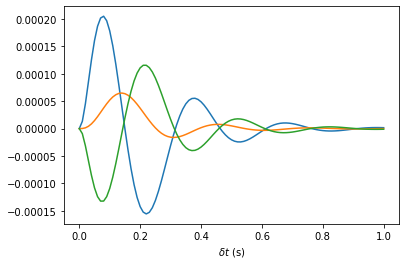

In [5]:
dt = 0.01
TKaxis = np.arange(101)*dt

psi = 0.3
k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)
plt.xlabel(r'$\delta t$ (s)')
plt.plot(TKaxis, -(k_E*(1-psi)-k_S*psi))

## Load and Check Input

In [6]:
dt = 0.01

annots = loadmat('D:\\GoogleDrive\\retina\\Exps\\2021\\1103\\SplitData\\diode_repeat_OU_tau=500ms_cutoff=1_mean=10_C=0.2_03-Nov-2021_0', squeeze_me = True)
sampling_rate = 20000
TimeStamps = annots['TimeStamps']
x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
T = np.arange(len(x))*dt

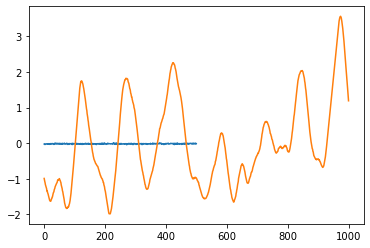

In [7]:
restTime = 5
stiTime = 10
trial = 20

plt.plot(x[:int(restTime/dt)])
plt.plot(x[int(restTime/dt):int((restTime+stiTime)/dt)])

xOri = x.copy()
x = x[int(restTime/dt):int((restTime+stiTime)/dt)]

In [8]:
amp = 2
mean = 10

psi = 0.3

apapt_step = int(1/dt)
eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,x*amp+mean)), k_E, 'full')[apapt_step:apapt_step+len(x)]
sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,x*amp+mean)), k_S, 'full')[apapt_step:apapt_step+len(x)]
output = -(eOutput*(1-psi)-sOutput*psi)

## Subtraction + GC (Gain act on both)

In [9]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

In [10]:
B_e = 3000 #To tune altitude of gain control (D=1/T)
tau_e = 0.1

B_s = 245.0 #To tune altitude of gain control (D=1/T)
tau_s = 0.6

Mean_list = [1,4,7,10,13]
Contrast_list = [0.05,0.1,0.2,0.3]
Data2DList = [[ {} for c in Contrast_list] for m in Mean_list]

for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        eOutput = np.convolve( np.hstack((np.ones(apapt_step)*Mean_list[mi],(x*Contrast_list[ci]+1)*Mean_list[mi])), k_E, 'full')[:apapt_step+len(x)]
        sOutput = np.convolve( np.hstack((np.ones(apapt_step)*Mean_list[mi],(x*Contrast_list[ci]+1)*Mean_list[mi])), k_S, 'full')[:apapt_step+len(x)]
        eOutput, _ = AddGainControl(eOutput, B_e, tau_e)    
        sOutput, _ = AddGainControl(sOutput, B_s, tau_s)

        Data2DList[mi][ci]['output'] = -eOutput[apapt_step:]*(1-psi)+sOutput[apapt_step:]*psi
    

## spike generation

In [11]:
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        r = Data2DList[mi][ci]['output']
        Spike_Trial = [0]*trial
        for ti in range(trial):
            Spike_Trial[ti] = Spike_Time_Generater( NL(r,np.mean(r)), dt, 10, 10)
        Data2DList[mi][ci]['Spike_Trial'] = Spike_Trial

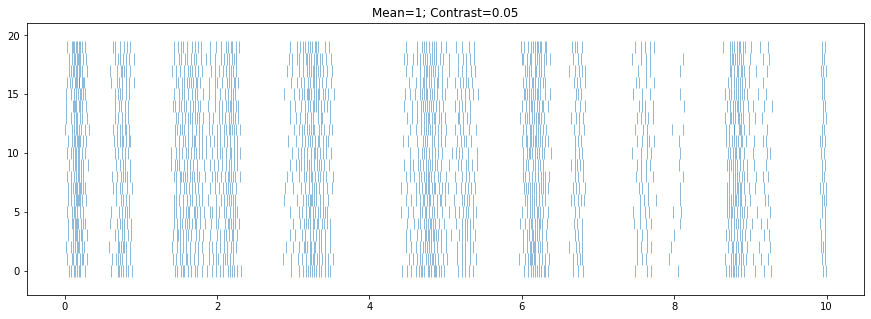

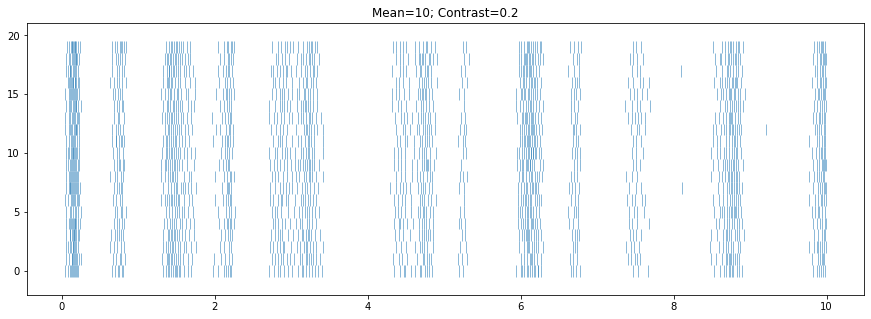

In [12]:
fig, ax = plt.subplots()
mi = 0
ci = 0
ax.eventplot(Data2DList[mi][ci]['Spike_Trial'], linewidths=0.5)
ax.set_title('Mean='+str(Mean_list[mi])+'; Contrast='+str(Contrast_list[ci]))
fig.set_size_inches(15, 5)

fig, ax = plt.subplots()
mi = 3
ci = 2
ax.eventplot(Data2DList[mi][ci]['Spike_Trial'], linewidths=0.5)
ax.set_title('Mean='+str(Mean_list[mi])+'; Contrast='+str(Contrast_list[ci]))
fig.set_size_inches(15, 5)

# varify Poison with variance-mean (Fano factor)

[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


Text(0.5, 1.0, 'stimulus: LPOU')

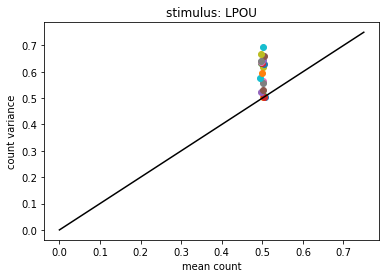

In [13]:
winSize = 0.05 # dt = 0.01
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Trial = Data2DList[mi][ci]['Spike_Trial']

        rstate_Trial = [0]*trial
        for ti in range(trial):
            rstate_Trial[ti], _ = np.histogram(Spike_Trial[ti], np.arange(int(stiTime/winSize)+1)*winSize)

        print(np.unique(np.array(rstate_Trial).flatten()))
        plt.scatter( np.mean(np.array(rstate_Trial).flatten()), np.var(np.array(rstate_Trial).flatten()))

plt.plot([0, 15*winSize], [0, 15*winSize], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulus: LPOU')

[ 97  98  99 100 101 102 103 104 105]
[ 93  94  95  96  98  99 100 101 103 104 106 107 109]
[ 93  95  98  99 100 101 102 103 105 108]
[ 96  97  98  99 100 101 102 103 104 106 107]
[ 93  95  96  97  98  99 100 101 102 103 104 107]
[ 96  97  98  99 100 101 102 103 104]
[ 94  98  99 100 101 102 103 104 105]
[ 95  97  98  99 100 101 102 104 105 106]
[ 97  98  99 100 101 102 103 104 107]
[ 91  96  97  98  99 100 101 102 104]
[ 96  97  98  99 100 101 102 103 104 107 108]
[ 89  96  98  99 100 101 102 103 104 105]
[ 92  96  97  98  99 100 101 103 104 107]
[ 95  96  98  99 101 102 103 104 105]
[ 93  94  96  97  98  99 100 103 104 105 106 108]
[ 95  96  98  99 100 101 102 103 104 105 106]
[ 92  93  94  96  97  98 100 101 103 105]
[ 95  96  97  98  99 100 101 102 103 107]
[ 92  95  96  97  98  99 100 101 103 106]
[ 91  97  98  99 100 101 102 103 104 105 106]


Text(0.5, 1.0, 'stimulus: LPOU')

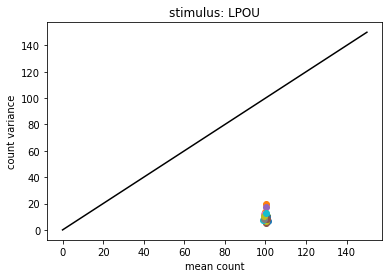

In [14]:
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Trial = Data2DList[mi][ci]['Spike_Trial']

        rstate_Trial = [0]*trial
        for ti in range(trial):
            rstate_Trial[ti] = len(Spike_Trial[ti])

        print(np.unique(np.array(rstate_Trial).flatten()))
        plt.scatter( np.mean(np.array(rstate_Trial).flatten()), np.var(np.array(rstate_Trial).flatten()))

plt.plot([0, 150], [0, 150], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulus: LPOU')

Text(0.5, 1.0, 'stimulus: LPOU')

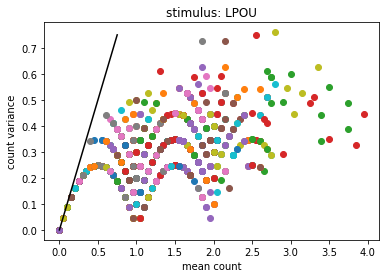

In [15]:
winSize = 0.05 # dt = 0.01
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        Spike_Trial = Data2DList[mi][ci]['Spike_Trial']

        rstate_Trial = [0]*trial
        for ti in range(trial):
            rstate_Trial[ti], _ = np.histogram(Spike_Trial[ti], np.arange(int(stiTime/winSize)+1)*winSize)
        for i in range(len(rstate_Trial[ti])):
            plt.scatter( np.mean(np.array(rstate_Trial)[:,i]), np.var(np.array(rstate_Trial)[:,i]))

plt.plot([0, 15*winSize], [0, 15*winSize], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulus: LPOU')